In [2]:
# DECISION TREE
#Q1

import pandas as pd
import numpy as np

def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(X)

def check_ifreal(y: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(y)

def entropy(Y: pd.Series) -> float:
    probs = Y.value_counts(normalize=True)
    return -np.sum(probs * np.log2(probs + 1e-9))

def gini_index(Y: pd.Series) -> float:
    probs = Y.value_counts(normalize=True)
    return 1 - np.sum(probs ** 2)

def mse(Y: pd.Series) -> float:
    return np.mean((Y - Y.mean()) ** 2)

def information_gain(Y: pd.Series, attr: pd.Series, criterion: str) -> float:
    if criterion == "information_gain":
        base = entropy(Y)
    elif criterion == "gini_index":
        base = gini_index(Y)
    else:
        raise ValueError("Invalid criterion")

    vals = attr.unique()
    split = 0.0
    for v in vals:
        mask = attr == v
        if criterion == "information_gain":
            split += (mask.sum() / len(Y)) * entropy(Y[mask])
        elif criterion == "gini_index":
            split += (mask.sum() / len(Y)) * gini_index(Y[mask])
    return base - split

def mse_gain(Y: pd.Series, attr: pd.Series) -> float:
    base_mse = mse(Y)
    vals = attr.unique()
    split_mse = 0.0
    for v in vals:
        mask = attr == v
        split_mse += (mask.sum() / len(Y)) * mse(Y[mask])
    return base_mse - split_mse

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion, features: pd.Series):
    best_gain = -np.inf
    best_attr, best_val = None, None
    for attr in features:
        x = X[attr]
        if pd.api.types.is_numeric_dtype(x):
            for val in np.unique(x):
                attr_col = x > val
                if check_ifreal(y):
                    gain = mse_gain(y, attr_col)
                else:
                    gain = information_gain(y, attr_col, criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_attr, best_val = attr, val




        else:
            for val in np.unique(x):
                attr_col = (x == val)
                if check_ifreal(y):
                    gain = mse_gain(y, attr_col)
                else:
                    gain = information_gain(y, attr_col, criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_attr, best_val = attr, val
    return best_attr, best_val

def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):
    if pd.api.types.is_numeric_dtype(X[attribute]):
        left_mask = X[attribute] > value
        right_mask = ~left_mask
    else:
        left_mask = X[attribute] == value
        right_mask = ~left_mask
    return (X[left_mask], y[left_mask]), (X[right_mask], y[right_mask])


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

class Node:
    def __init__(self, depth=0, max_depth=5):
        self.feature = None
        self.value = None
        self.left = None
        self.right = None
        self.output = None
        self.depth = depth
        self.max_depth = max_depth

    def is_leaf(self):
        return self.output is not None

class DecisionTree:
    def __init__(self, criterion, max_depth=5):
        self.criterion = criterion  # "information_gain" or "gini_index"
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        if not check_ifreal(X.values.flatten()):
            X = one_hot_encoding(X)
        self.features = X.columns.tolist()
        self.tree = self._fit(X, y, 0)

    def _fit(self, X, y, depth):
        node = Node(depth=depth, max_depth=self.max_depth)
        if depth >= self.max_depth or len(y.unique()) == 1 or len(y) < 2:
            node.output = y.mode()[0] if not check_ifreal(y) else y.mean()
            return node

        best_attr, best_val = opt_split_attribute(X, y, self.criterion, self.features)
        node.feature = best_attr
        node.value = best_val

        (X_left, y_left), (X_right, y_right) = split_data(X, y, best_attr, best_val)
        if len(y_left) == 0 or len(y_right) == 0:
            node.output = y.mode()[0] if not check_ifreal(y) else y.mean()
            return node

        node.left = self._fit(X_left, y_left, depth + 1)
        node.right = self._fit(X_right, y_right, depth + 1)
        return node

    def predict(self, X: pd.DataFrame) -> pd.Series:
        if not check_ifreal(X.values.flatten()):
            X = one_hot_encoding(X)
        y_hat = []
        for _, row in X.iterrows():
            y_hat.append(self._predict_row(row, self.tree))
        return pd.Series(y_hat)

    def _predict_row(self, row, node):
        while node.left and node.right:
            if pd.api.types.is_numeric_dtype(row[node.feature]):
                if row[node.feature] > node.value:
                    node = node.left
                else:
                    node = node.right
            else:
                if row[node.feature] == node.value:
                    node = node.left
                else:
                    node = node.right
        return node.output

    def plot(self) -> None:
        self._plot(self.tree)

    def _plot(self, node, depth=0):
        prefix = "    " * depth
        if node.is_leaf():
            print(f"{prefix}Leaf: {node.output}")
            return
        ques = f"{node.feature} > {node.value}" if pd.api.types.is_numeric_dtype(node.value) else f"{node.feature} == {node.value}"
        print(f"{prefix}?({ques})")
        print(f"{prefix}Y:")
        self._plot(node.left, depth + 1)
        print(f"{prefix}N:")
        self._plot(node.right, depth + 1)


In [4]:
from typing import Union
import pandas as pd
import numpy as np

def accuracy(y_hat: pd.Series, y: pd.Series) -> float:
    assert y_hat.size == y.size
    if y.size == 0:
        return 0.0
    return (y_hat == y).sum() / y.size

def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    tp = ((y_hat == cls) & (y == cls)).sum()
    fp = ((y_hat == cls) & (y != cls)).sum()
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    tp = ((y_hat == cls) & (y == cls)).sum()
    fn = ((y_hat != cls) & (y == cls)).sum()
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    assert y_hat.size == y.size
    return np.sqrt(np.mean((y_hat - y) ** 2))

def mae(y_hat: pd.Series, y: pd.Series) -> float:
    assert y_hat.size == y.size
    return np.mean(np.abs(y_hat - y))


In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Test case 1: Real Input and Real Output
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria:", criteria)
    print("RMSE:", rmse(y_hat, y))
    print("MAE:", mae(y_hat, y))
    print()

# Test case 2: Real Input and Discrete Output
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria:", criteria)
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision:", precision(y_hat, y, cls))
        print("Recall:", recall(y_hat, y, cls))
    print()

# Test case 3: Discrete Input and Discrete Output
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria:", criteria)
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision:", precision(y_hat, y, cls))
        print("Recall:", recall(y_hat, y, cls))
    print()

# Test case 4: Discrete Input and Real Output
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria:", criteria)
    print("RMSE:", rmse(y_hat, y))
    print("MAE:", mae(y_hat, y))
    print()


?(1 > -1.236950710878082)
Y:
    ?(4 > 0.25988279424842353)
    Y:
        ?(0 > -0.47917423784528995)
        Y:
            ?(4 > 0.9755451271223592)
            Y:
                Leaf: -0.9746816702273214
            N:
                ?(0 > 0.7910319470430469)
                Y:
                    Leaf: 0.787084603742452
                N:
                    Leaf: 0.3214303278812129
        N:
            ?(0 > -0.5017570435845365)
            Y:
                Leaf: 1.158595579007404
            N:
                ?(0 > -0.6017066122293969)
                Y:
                    Leaf: 1.8967929826539474
                N:
                    Leaf: 1.8657745111447566
    N:
        ?(0 > 1.465648768921554)
        Y:
            ?(0 > 1.5499344050175394)
            Y:
                Leaf: 0.8271832490360238
            N:
                Leaf: 1.4535340771573169
        N:
            ?(4 > -1.763040155362734)
            Y:
                ?(2 > 1.0035328978920242)
         

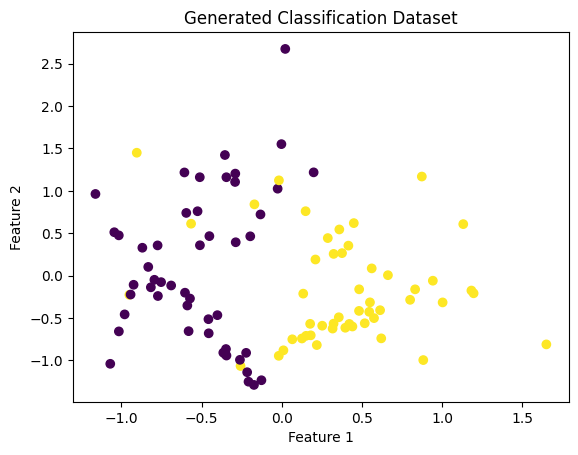

Accuracy on test set: 0.9000

Class 1: Precision = 0.8947, Recall = 0.9444

Custom Decision Tree Structure (textual):
?(Feature_1 > 0.0218089842466217)
Y:
    Leaf: 1
N:
    ?(Feature_1 > -0.1732591914514583)
    Y:
        ?(Feature_1 > -0.01770274131829863)
        Y:
            Leaf: 0
        N:
            ?(Feature_1 > -0.025688429305686322)
            Y:
                Leaf: 1
            N:
                ?(Feature_1 > -0.17046480899914696)
                Y:
                    Leaf: 0
                N:
                    Leaf: 1
    N:
        ?(Feature_2 > 1.2171855904392395)
        Y:
            Leaf: 1
        N:
            ?(Feature_2 > -1.0662979526093899)
            Y:
                ?(Feature_2 > -0.24054893918459608)
                Y:
                    Leaf: 0
                N:
                    Leaf: 0
            N:
                ?(Feature_1 > -0.2569428946729052)
                Y:
                    Leaf: 0
                N:
                  

In [11]:
#DECISION TREE
#Q2A

from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate classification dataset
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=2,
    class_sep=0.5
)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Generated Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Convert to DataFrame / Series
X_df = pd.DataFrame(X, columns=["Feature_1", "Feature_2"])
y_ser = pd.Series(y, dtype="category")

# Split 70% train, 30% test
split_idx = int(0.7 * len(y_ser))
X_train, X_test = X_df.iloc[:split_idx], X_df.iloc[split_idx:]
y_train, y_test = y_ser.iloc[:split_idx], y_ser.iloc[split_idx:]

# Instantiate and train DecisionTree
tree = DecisionTree(criterion="gini_index", max_depth=5)
tree.fit(X_train, y_train)

# Predict on test set
y_pred = tree.predict(X_test)
y_pred = y_pred.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Print metrics
acc = accuracy(y_pred, y_test)
print(f"Accuracy on test set: {acc:.4f}\n")

for cls in y_ser.unique():
    p = precision(y_pred, y_test, cls)
    r = recall(y_pred, y_test, cls)
    print(f"Class {cls}: Precision = {p:.4f}, Recall = {r:.4f}")
    print("\nCustom Decision Tree Structure (textual):")
    tree.plot()




In [13]:
#DECISION TREE
#Q2B

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate dataset
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=2,
    class_sep=0.5
)
X_df = pd.DataFrame(X, columns=["Feature_1", "Feature_2"])
y_ser = pd.Series(y, dtype="category")

# Hyperparameter grid for tree depth
depth_grid = [1, 2, 3, 4, 5, 6, 7, 8]

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_accuracies = []
depths_chosen = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_df)):
    print(f"\nOuter Fold {fold_idx+1}/5")
    X_train_outer, X_test_outer = X_df.iloc[train_idx], X_df.iloc[test_idx]
    y_train_outer, y_test_outer = y_ser.iloc[train_idx], y_ser.iloc[test_idx]

    inner_cv = KFold(n_splits=3, shuffle=True, random_state=fold_idx+100)
    depth_accs = []
    for depth in depth_grid:
        inner_accs = []
        for in_train_idx, in_val_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[in_train_idx], X_train_outer.iloc[in_val_idx]
            y_train_inner, y_val_inner = y_train_outer.iloc[in_train_idx], y_train_outer.iloc[in_val_idx]
            tree = DecisionTree(criterion="gini_index", max_depth=depth)
            tree.fit(X_train_inner, y_train_inner)
            y_pred_inner = tree.predict(X_val_inner).reset_index(drop=True)
            y_val_inner = y_val_inner.reset_index(drop=True)
            inner_accs.append(accuracy(y_pred_inner, y_val_inner))
        depth_accs.append(np.mean(inner_accs))

    best_depth = depth_grid[np.argmax(depth_accs)]
    depths_chosen.append(best_depth)
    print(f"  Chosen optimal depth from inner CV: {best_depth} (mean inner CV accuracy = {max(depth_accs):.4f})")

    # Train on whole outer training set at best depth, evaluate outer test set
    final_tree = DecisionTree(criterion="gini_index", max_depth=best_depth)
    final_tree.fit(X_train_outer, y_train_outer)
    y_pred_outer = final_tree.predict(X_test_outer).reset_index(drop=True)
    y_test_outer = y_test_outer.reset_index(drop=True)
    acc = accuracy(y_pred_outer, y_test_outer)
    outer_accuracies.append(acc)
    print(f"  Outer Test Accuracy: {acc:.4f}")
    for cls in y_ser.unique():
        p = precision(y_pred_outer, y_test_outer, cls)
        r = recall(y_pred_outer, y_test_outer, cls)
        print(f"    Class {cls}: Precision = {p:.4f}, Recall = {r:.4f}")

print("\nSummary:")
print("Mean Outer Test Accuracy over 5 folds: {:.4f}".format(np.mean(outer_accuracies)))
print("Depth chosen in each fold:", depths_chosen)
print("Accuracy in each fold:", np.round(outer_accuracies, 4))
from collections import Counter
optimum_depth = Counter(depths_chosen).most_common(1)[0][0]
print(f"\nThe optimum depth chosen by nested cross-validation is: {optimum_depth}")
print(f"This depth is optimum because it achieved the highest mean validation accuracy across inner folds in most outer cross-validation splits. Using nested CV finds the depth that best generalizes, not just fits the training data, so your tree avoids overfitting and has reliable test accuracy.")



Outer Fold 1/5
  Chosen optimal depth from inner CV: 1 (mean inner CV accuracy = 0.8879)
  Outer Test Accuracy: 0.9500
    Class 1: Precision = 1.0000, Recall = 0.9000
    Class 0: Precision = 0.9091, Recall = 1.0000

Outer Fold 2/5
  Chosen optimal depth from inner CV: 1 (mean inner CV accuracy = 0.9012)
  Outer Test Accuracy: 0.8000
    Class 1: Precision = 0.8750, Recall = 0.7000
    Class 0: Precision = 0.7500, Recall = 0.9000

Outer Fold 3/5
  Chosen optimal depth from inner CV: 1 (mean inner CV accuracy = 0.9259)
  Outer Test Accuracy: 0.8500
    Class 1: Precision = 0.8000, Recall = 0.8889
    Class 0: Precision = 0.9000, Recall = 0.8182

Outer Fold 4/5
  Chosen optimal depth from inner CV: 2 (mean inner CV accuracy = 0.8884)
  Outer Test Accuracy: 0.9500
    Class 1: Precision = 1.0000, Recall = 0.9000
    Class 0: Precision = 0.9091, Recall = 1.0000

Outer Fold 5/5
  Chosen optimal depth from inner CV: 1 (mean inner CV accuracy = 0.8504)
  Outer Test Accuracy: 0.9500
    Clas

In [8]:


#DECISION TREE

#Q3A B

# import pandas as pd
# import numpy as np
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# np.random.seed(42)

# # Load and preprocess Auto-MPG dataset
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# data = pd.read_csv(url, delim_whitespace=True, header=None,
#                    names=["mpg", "cylinders", "displacement", "horsepower", "weight",
#                           "acceleration", "model year", "origin", "car name"])

# # Data cleaning
# data = data.replace('?', np.nan).dropna()
# data = data.drop(columns=["car name"])
# data['horsepower'] = data['horsepower'].astype(float)

# # Features and target
# X = data.drop(columns=["mpg"])
# y = data["mpg"]

# # One-hot encode categorical variables
# X = pd.get_dummies(X, columns=["origin", "cylinders", "model year"])

# # Train-test split (70% train)
# split_idx = int(0.7 * len(data))
# X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
# y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# # === Custom regression Decision Tree implementation using MSE splitting ===
# # (Use the DecisionTree class code that uses mse_gain, mse, opt_split_attribute as provided earlier)

# # Initialize and train custom regression tree
# # tree = DecisionTree(max_depth=5)
# tree = DecisionTree(criterion="mse", max_depth=5)

# tree.fit(X_train, y_train)
# y_pred_custom = tree.predict(X_test).reset_index(drop=True)
# y_test_reset = y_test.reset_index(drop=True)

# print("Custom DecisionTree (Regression):")
# print("RMSE:", np.sqrt(np.mean((y_pred_custom - y_test_reset) ** 2)))
# print("MAE:", np.mean(np.abs(y_pred_custom - y_test_reset)))

# # === Scikit-learn DecisionTreeRegressor ===
# sk_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
# sk_tree.fit(X_train, y_train)
# y_pred_sk = sk_tree.predict(X_test)

# print("\nScikit-learn DecisionTreeRegressor:")
# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sk)))
# print("MAE:", mean_absolute_error(y_test, y_pred_sk))

















import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

np.random.seed(42)

# Load and preprocess Auto-MPG dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data = pd.read_csv(url, delim_whitespace=True, header=None,
                   names=["mpg", "cylinders", "displacement", "horsepower", "weight",
                          "acceleration", "model year", "origin", "car name"])

data = data.replace('?', np.nan).dropna()
data = data.drop(columns=["car name"])
data['horsepower'] = data['horsepower'].astype(float)

X = data.drop(columns=["mpg"])
y = data["mpg"]
X = pd.get_dummies(X, columns=["origin", "cylinders", "model year"])

# Train-test split (70% train)
split_idx = int(0.7 * len(data))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- Nested KFold ON CUSTOM TREE ONLY ---
depth_grid = [2, 3, 4, 5, 6, 7, 8]
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_rmse_custom, depths_chosen_custom = [], []

# y_tests_all_folds_custom = []
# y_preds_all_folds_custom = []

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train)):
    print(f"\nOuter Fold {outer_fold+1}/5")

    X_train_outer, X_val_outer = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_outer, y_val_outer = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # ------ Inner CV for Custom DecisionTree ------
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=outer_fold+100)
    depth_rmse_means = []
    for depth in depth_grid:
        inner_rmses = []
        for in_train_idx, in_val_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[in_train_idx], X_train_outer.iloc[in_val_idx]
            y_train_inner, y_val_inner = y_train_outer.iloc[in_train_idx], y_train_outer.iloc[in_val_idx]
            tree = DecisionTree(criterion="mse", max_depth=depth)
            tree.fit(X_train_inner, y_train_inner)
            y_pred_inner = tree.predict(X_val_inner).reset_index(drop=True)
            y_val_inner = y_val_inner.reset_index(drop=True)
            inner_rmses.append(np.sqrt(mean_squared_error(y_val_inner, y_pred_inner)))
        depth_rmse_means.append(np.mean(inner_rmses))
    best_depth_custom = depth_grid[np.argmin(depth_rmse_means)]
    print(f"  Custom Tree: Optimal depth from inner CV = {best_depth_custom} (mean inner RMSE = {min(depth_rmse_means):.4f})")
    depths_chosen_custom.append(best_depth_custom)

    # Retrain on whole outer-training set with best depth, evaluate on validation fold
    tree_final = DecisionTree(criterion="mse", max_depth=best_depth_custom)
    tree_final.fit(X_train_outer, y_train_outer)

    print("\nCustom Decision Tree Structure (textual):")
    tree_final.plot()

    y_pred_outer_custom = tree_final.predict(X_val_outer).reset_index(drop=True)
    y_val_outer = y_val_outer.reset_index(drop=True)
    rmse_custom = np.sqrt(mean_squared_error(y_val_outer, y_pred_outer_custom))
    outer_rmse_custom.append(rmse_custom)
    print(f"  Custom Tree Outer Validation RMSE: {rmse_custom:.4f}")

# Fit and Evaluate sklearn DecisionTreeRegressor on train/test split (no KFold)
sk_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
sk_tree.fit(X_train, y_train)
y_pred_sk = sk_tree.predict(X_test)
rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_sk))
mae_sk = mean_absolute_error(y_test, y_pred_sk)

print("\nSummary over 5 outer folds (nested KFold on Custom Tree):")
print("Custom Tree: Mean Outer Validation RMSE: {:.4f}".format(np.mean(outer_rmse_custom)))
print("Custom Tree: Depths chosen per fold:", depths_chosen_custom)

print("\nScikit-learn DecisionTreeRegressor (no CV, max_depth=5):")
print(f"Test RMSE: {rmse_sk:.4f}")
print(f"Test MAE: {mae_sk:.4f}")


# y_test_all_custom = pd.concat(y_tests_all_folds_custom).reset_index(drop=True)
# y_pred_all_custom = pd.concat(y_preds_all_folds_custom).reset_index(drop=True)





/tmp/ipython-input-2715210070.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True, header=None,



Outer Fold 1/5
  Custom Tree: Optimal depth from inner CV = 2 (mean inner RMSE = 12.6336)

Custom Decision Tree Structure (textual):
?(cylinders_4 > False)
Y:
    ?(weight > 2219.0)
    Y:
        Leaf: 23.78125
    N:
        Leaf: 30.363636363636363
N:
    ?(displacement > 262.0)
    Y:
        Leaf: 14.258571428571429
    N:
        Leaf: 18.9
  Custom Tree Outer Validation RMSE: 12.1826

Outer Fold 2/5
  Custom Tree: Optimal depth from inner CV = 2 (mean inner RMSE = 13.5477)

Custom Decision Tree Structure (textual):
?(cylinders_4 > False)
Y:
    ?(weight > 2075.0)
    Y:
        Leaf: 24.510344827586206
    N:
        Leaf: 31.964285714285715
N:
    ?(displacement > 262.0)
    Y:
        Leaf: 14.185915492957747
    N:
        Leaf: 19.040322580645157
  Custom Tree Outer Validation RMSE: 12.6873

Outer Fold 3/5
  Custom Tree: Optimal depth from inner CV = 2 (mean inner RMSE = 12.9671)

Custom Decision Tree Structure (textual):
?(cylinders_4 > False)
Y:
    ?(weight > 2074.0)
   

Case 1, N=50, P=3: Fit 0.5584s, Predict 0.0024s
Case 1, N=50, P=6: Fit 1.1903s, Predict 0.0039s
Case 1, N=50, P=12: Fit 2.7807s, Predict 0.0024s
Case 1, N=150, P=3: Fit 1.5013s, Predict 0.0066s
Case 1, N=150, P=6: Fit 3.0541s, Predict 0.0065s
Case 1, N=150, P=12: Fit 6.5369s, Predict 0.0099s
Case 2, N=50, P=3: Fit 1.2947s, Predict 0.0024s
Case 2, N=50, P=6: Fit 1.8683s, Predict 0.0026s
Case 2, N=50, P=12: Fit 3.5879s, Predict 0.0022s
Case 2, N=150, P=3: Fit 2.8658s, Predict 0.0066s
Case 2, N=150, P=6: Fit 6.4332s, Predict 0.0067s
Case 2, N=150, P=12: Fit 12.1509s, Predict 0.0067s
Case 3, N=50, P=3: Fit 0.1655s, Predict 0.0047s
Case 3, N=50, P=6: Fit 0.4070s, Predict 0.0059s
Case 3, N=50, P=12: Fit 0.8673s, Predict 0.0087s
Case 3, N=150, P=3: Fit 0.1888s, Predict 0.0099s
Case 3, N=150, P=6: Fit 0.4309s, Predict 0.0111s
Case 3, N=150, P=12: Fit 0.8752s, Predict 0.0136s
Case 4, N=50, P=3: Fit 0.1018s, Predict 0.0047s
Case 4, N=50, P=6: Fit 0.2466s, Predict 0.0085s
Case 4, N=50, P=12: Fit 

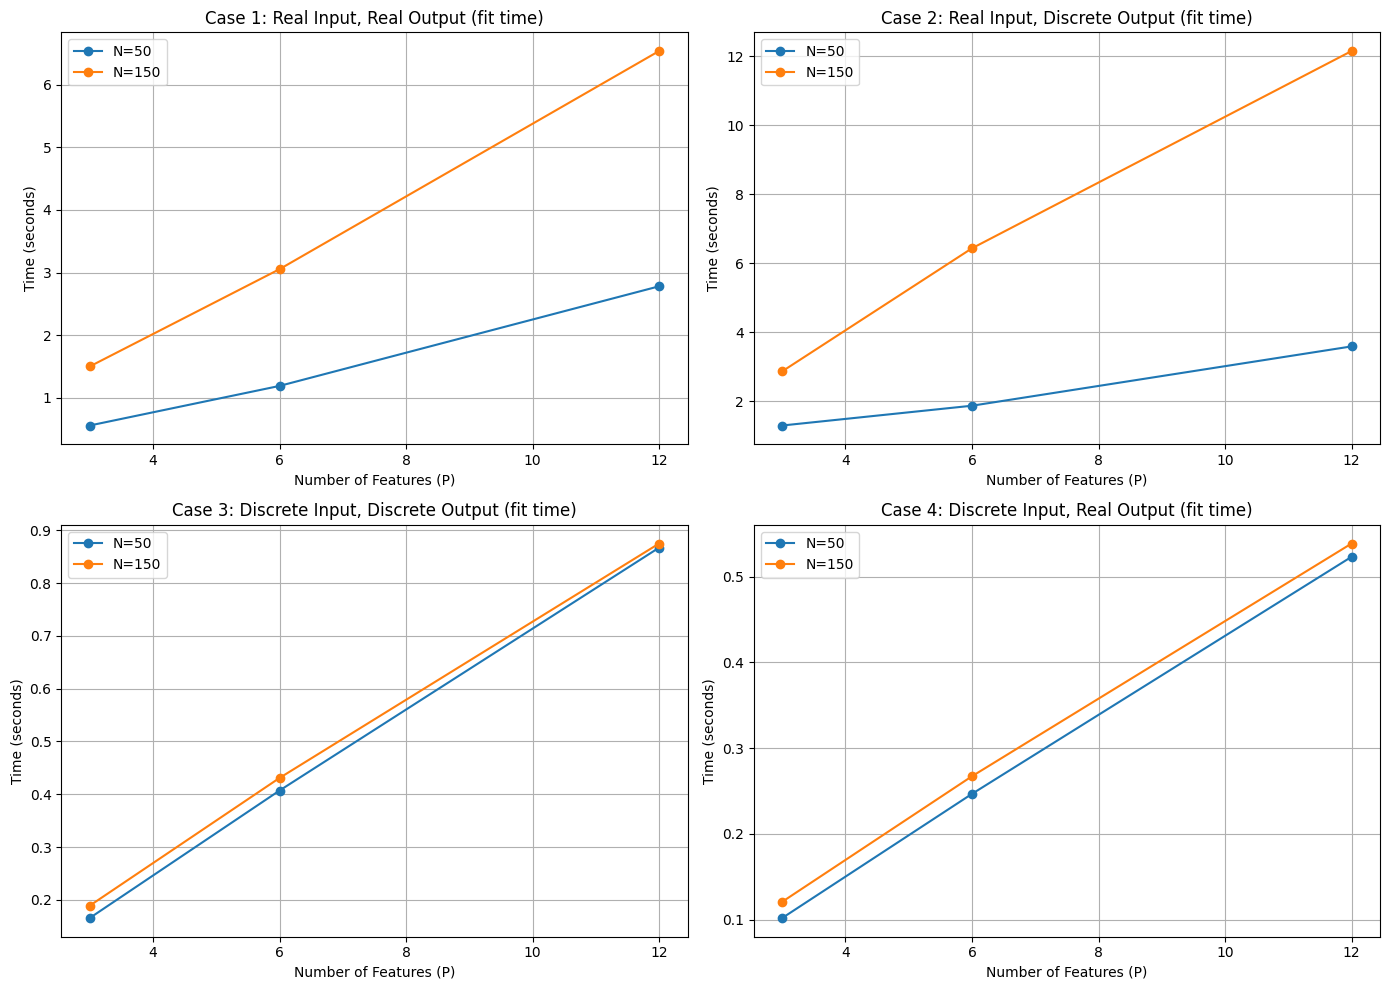

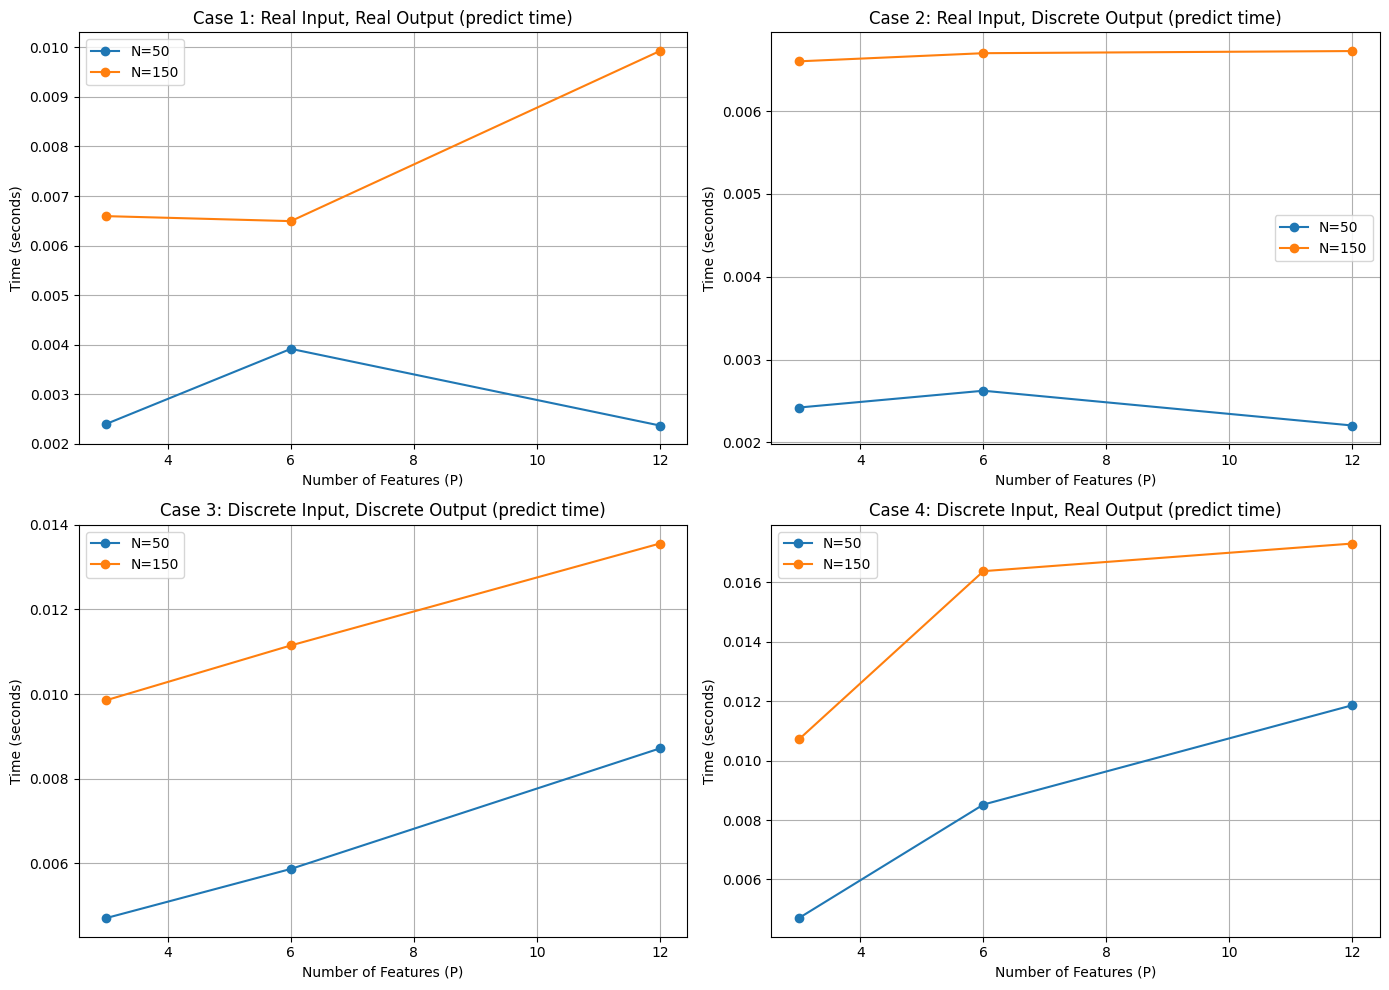

In [9]:


#DECISION TREE
#Q4

#Theoritical time complexity for training is O(MNlogN)
#Theoritical time complexity for precition is O(logN)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(42)
num_average_time = 1  # single run for quick timings

def create_fake_data(N, P, case):
    if case == 1:
        X = pd.DataFrame(np.random.randn(N, P))
        y = pd.Series(np.random.randn(N))
    elif case == 2:
        X = pd.DataFrame(np.random.randn(N, P))
        y = pd.Series(np.random.randint(0, 3, size=N), dtype="category")
    elif case == 3:
        X = pd.DataFrame({i: pd.Series(np.random.randint(0, 3, size=N), dtype="category") for i in range(P)})
        y = pd.Series(np.random.randint(0, 3, size=N), dtype="category")
    elif case == 4:
        X = pd.DataFrame({i: pd.Series(np.random.randint(0, 3, size=N), dtype="category") for i in range(P)})
        y = pd.Series(np.random.randn(N))
    else:
        raise ValueError("Case must be 1, 2, 3, or 4")
    return X, y

def time_decision_tree(N_values, P_values, num_runs=num_average_time):
    results = {}
    cases = [1,2,3,4]
    for case in cases:
        for N in N_values:
            for P in P_values:
                fit_times = []
                pred_times = []
                for _ in range(num_runs):
                    X, y = create_fake_data(N, P, case)
                    tree = DecisionTree(criterion=("gini_index" if not check_ifreal(y) else "information_gain"), max_depth=3)
                    start_fit = time.time()
                    tree.fit(X, y)
                    fit_times.append(time.time()-start_fit)

                    start_pred = time.time()
                    _ = tree.predict(X)
                    pred_times.append(time.time()-start_pred)

                results.setdefault((case,N), {})[P] = {"fit": np.mean(fit_times), "predict": np.mean(pred_times)}
                print(f"Case {case}, N={N}, P={P}: Fit {results[(case,N)][P]['fit']:.4f}s, Predict {results[(case,N)][P]['predict']:.4f}s")
    return results

def plot_results(results, N_values, P_values, metric="fit"):
    case_names = {1:"Real Input, Real Output", 2:"Real Input, Discrete Output",
                  3:"Discrete Input, Discrete Output", 4:"Discrete Input, Real Output"}
    plt.figure(figsize=(14,10))
    for case in [1,2,3,4]:
        plt.subplot(2,2,case)
        for N in N_values:
            times = [results[(case,N)][P][metric] for P in P_values]
            plt.plot(P_values, times, marker='o', label=f"N={N}")
        plt.title(f"Case {case}: {case_names[case]} ({metric} time)")
        plt.xlabel("Number of Features (P)")
        plt.ylabel("Time (seconds)")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Smaller parameter grid for fast run
N_values = [50, 150]
P_values = [3, 6, 12]

results = time_decision_tree(N_values, P_values)

plot_results(results, N_values, P_values, metric="fit")
plot_results(results, N_values, P_values, metric="predict")
